# Building and Testing Corrective RAG



[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

Here's we're going to show two different way to implement Corrective-RAG:

(1) We will implement this as a [ReAct agent](https://react-lm.github.io/).

(2) We will implement this agent as a custom / user-defined control flow in LangGraph.

Then, we will show how to test these agents.

(1) We'll build an [evaluation set of question-answer pairs for RAG in LangSmith](https://docs.smith.langchain.com/tutorials/Developers/agents#eval).

(2) We'll evaluate end-to-end performance of our agents along with the specific reasoning trace of each one.

This notebook will reference ideas from [these slides](https://docs.google.com/presentation/d/1QWkXi4DYjfw94eHcy9RMLqpQdJtS2C_kx_u7wAUvlZE/edit?usp=sharing).

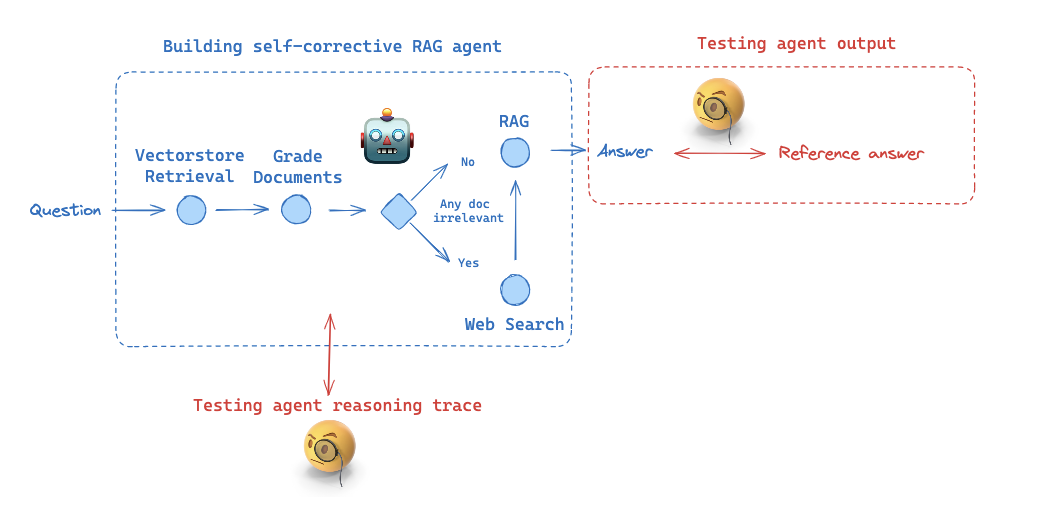

## Environment

We'll start with [OpenAI](https://python.langchain.com/v0.2/docs/integrations/chat/openai/) as our LLM, but this can be easily swapped. Optionally, we also show [Fireworks](https://fireworks.ai/).

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use [Chroma](https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/) as our vectorstore with [OpenAI embeddings](https://python.langchain.com/v0.2/docs/integrations/text_embedding/openai/#embed-documents).

We'll use [LangSmith](https://docs.smith.langchain.com/) for tracing and evaluation.

In [2]:
%%capture --no-stderr
%pip install -U langchain tavily-python langgraph matplotlib langchain_community tiktoken langchain-openai scikit-learn langchain_fireworks langchainhub beautifulsoup4

In [1]:
import getpass
import os
from dotenv import load_dotenv
load_dotenv('../../azure.env')
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-06-01"
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = 'gpt-4o'

You can also set API keys and env variables here:

In [3]:
os.environ["TAVILY_API_KEY"] = getpass.getpass()

## LLM

Select the LLM to use for both of our agents.

This can be easily swapped with [other models that support tool use](https://python.langchain.com/v0.2/docs/integrations/chat/)!

In [4]:
from langchain_openai import AzureChatOpenAI

model = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

In [5]:
model_tested = "gpt-4o"
metadata = "CRAG, gpt-4o"

For example, we can also test [Firefunction-v2](https://fireworks.ai/blog/firefunction-v2-launch-post), a Llama 3-70b fine-tuned for tool calling.

from langchain_fireworks import ChatFireworks
model_tested = "firefunction-v2"
metadata = "CRAG, firefunction-v"
llm = ChatFireworks(model="accounts/fireworks/models/firefunction-v2", temperature=0)

## ReAct Agent

First, we'll define our [ReAct agent](https://python.langchain.com/v0.2/docs/tutorials/agents/) for corrective RAG!

LLM powered autonomous agents [use three things to accomplish tasks](https://lilianweng.github.io/posts/2023-06-23-agent/):

- `Tools`: Actions to gather external information that is missing from the model weights
- `Planning`: Often this is self-criticism and self-reflection over past actions
- `Memory`: Ability to recall information (e.g., from the user or from past actions)

[ReAct](https://arxiv.org/abs/2210.03629) is a popular that incorporates explicit steps for LLM to:

- `Action`: Choose an action (e.g., often a tool)
- `Observation`: Observe the outputs of the action
- `Think`: Reason about the next step

These steps follow a loop until the agent stops calling tools and decides to return a final answer.

Let's set up our ReAct agent by first defining a few tools.

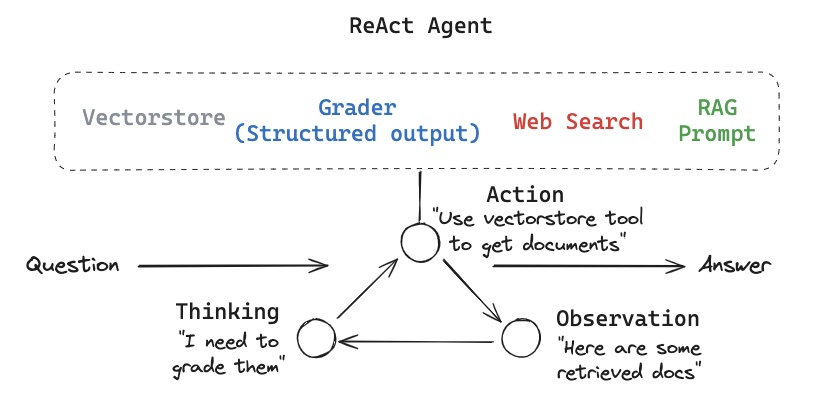

### Tools

First, we'll index 3 blog posts and store them in a vectorstore, [Chroma](https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/) and define [this as a tool](https://python.langchain.com/v0.2/docs/concepts/#tools).


In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import AzureOpenAIEmbeddings
from langchain_core.tools import tool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
embeddings = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-small",
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

In [9]:
# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using OpenAIEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=4)

When we define this as a `tool` and bind it too the LLM, then the LLM can:

* Choose to call this tool
* Formulate the payload needed to run the tool

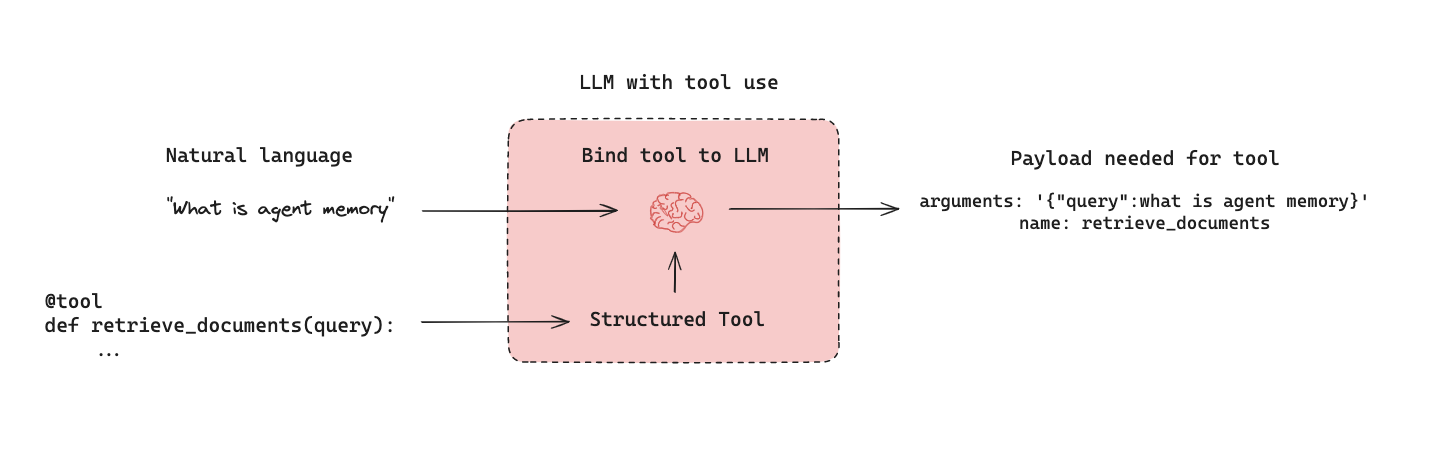

In [10]:
# Define a tool, which we will connect to our agent
@tool
def retrieve_documents(query: str) -> list:
    """Retrieve documents from the vector store based on the query."""
    return retriever.invoke(query)

We'll create a tool that instructs our agent to reflect on the retrieved documents.


In [11]:
@tool
def grade_document_retrieval(step_by_step_reasoning: str, score: int) -> str:
    """You are a teacher grading a quiz. You will be given:
    1/ a QUESTION
    2/ a set of comma separated FACTS provided by the student

    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the FACTS are relevant to the QUESTION.
    A score of 0 means that NONE of the FACTS are relevant to the QUESTION.

    If your score is 1: then call a tool to generate the answer, generate_answer
    If your score is 0: then call a tool to perform web search, web_search."""
    if score == 1:
        return "Docs are relevant. Generate the answer to the question."
    return "Docs are not relevant. Use web search to find more documents."

We'll create a tool for web search using Tavily.


In [12]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()


@tool
def web_search(query: str) -> str:
    """Run web search on the question."""
    web_results = web_search_tool.invoke({"query": query})
    return [
        Document(page_content=d["content"], metadata={"url": d["url"]})
        for d in web_results
    ]

Finally, we'll create a tool that instructs our agent to produce the final distillated answer.

In [13]:
@tool
def generate_answer(answer: str) -> str:
    """You are an assistant for question-answering tasks.
    Use the retrieved documents to answer the user question.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise"""
    return f"Here is the answer to the user question: {answer}"

Now, we store these in a tools list, which we will bind to our LLM.


In [14]:
tools = [retrieve_documents, grade_document_retrieval, web_search, generate_answer]

### Planning

Now, we'll define an LLM assistant for our agent, which can use the tools we defined above.


In [15]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the model and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Create the primary assistant prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant tasked with answering user questions using the provided vector store. "
            " Use the provided vector store to retrieve documents. Then grade them to ensure they are relevant before answering the question. "
        ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | model.bind_tools(tools)

### Memory

Finally, we'll using [LangGraph](https://langchain-ai.github.io/langgraph/) to orchestrate our agent.

LangGraph is a library for building agents, which allows us to define 2 nodes:

- `Assistant`, which will contain the `assistant_runnable` defined above
- `Tool`, which will call the tool when the assistant instructs and return the tool outputs to our assistant

LangGraph allows us to define state, which will serve as short-term memory over the lifetime of our agent.

First, there are some utilities that we'll use to help define the graph.

In [16]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

Now, we'll define our graph.

We'll simply cycle between 2 nodes:

* Our `assistant` node reasons and plans which tool to use
* Our `tool` node that executes the tool

It will continue as long as our `assistant` is making a tool call.

This shows the general flow:

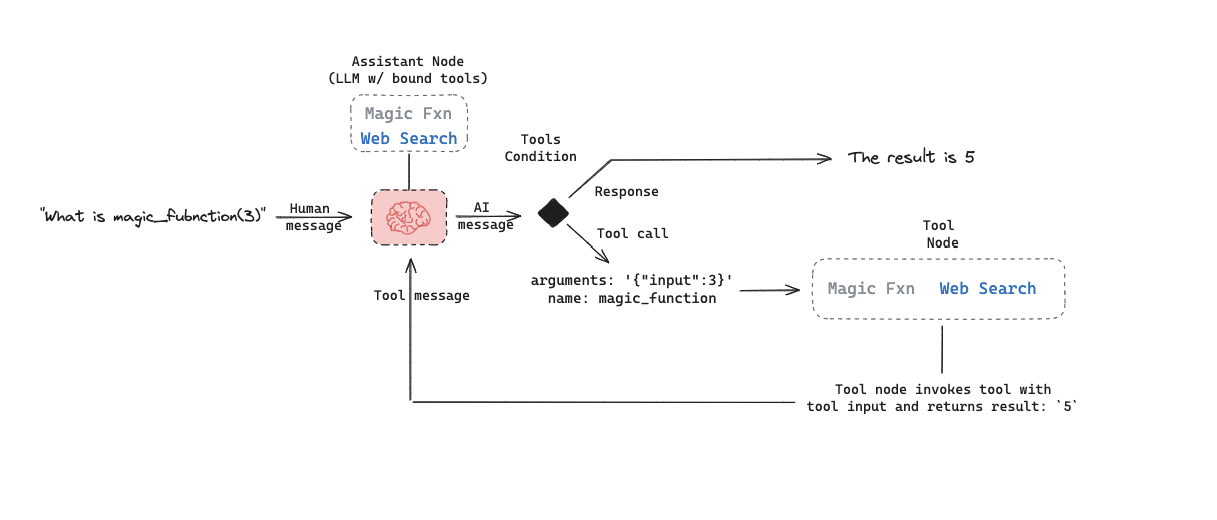

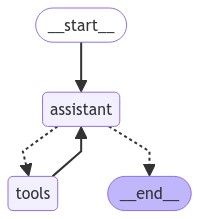

In [17]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Finally, we can our agent!


In [18]:
import uuid


def predict_react_agent_answer(example: dict):
    """Use this for answer evaluation"""

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    messages = react_graph.invoke({"messages": ("user", example["input"])}, config)
    return {"response": messages["messages"][-1].content, "messages": messages}


example = {"input": "What are the types of agent memory?"}
response = predict_react_agent_answer(example)

In [20]:
response

{'response': "The types of agent memory include short-term memory, long-term memory, and memory stream. Short-term memory involves in-context learning, long-term memory allows the agent to retain and recall information over extended periods using external vector stores, and memory stream is a long-term memory module recording the agent's experiences in natural language.",
 'messages': {'messages': [HumanMessage(content='What are the types of agent memory?', id='f2873849-ebd4-41b7-a0f8-3c7157c82869'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gyKkX9PzzK7E03BNJULEwhCA', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_documents'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 320, 'total_tokens': 337}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False,

In [19]:
def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned from the ReAct agent
    """
    tool_calls = [
        tc["name"] for m in messages["messages"] for tc in getattr(m, "tool_calls", [])
    ]
    return tool_calls

find_tool_calls_react(response['messages'])

['retrieve_documents', 'grade_document_retrieval', 'generate_answer']

With LangSmith set, we can see the trace:

https://smith.langchain.com/public/3e897f96-c224-4c93-8bc0-60b8285d0813/r

We see follow the tool calls to clearly see the reasoning trace:

* Our agent first calls `retrieve_documents` tool to get documents.

* Then, it calls `grade_document_retrieval` tool and deems the documents to be relevant.

## Custom LangGraph Agent

Now, we'll do the same as shown above. But rather that following the ReAct agent control flow, we'll use a custom control flow.

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

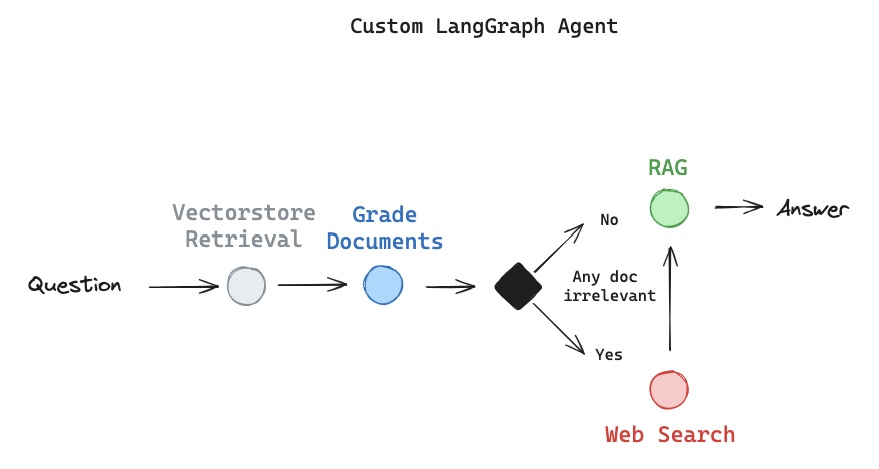

First, we'll define a RAG chain to produce our final answer.


In [21]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.

    Use the following documents to answer the question.

    If you don't know the answer, just say that you don't know.

    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Documents: {documents}
    Answer:
    """,
    input_variables=["question", "documents"],
)

rag_chain = prompt | model | StrOutputParser()

Now, we'll define a document grader to review our documents.


In [22]:
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model for the output
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with tool call
structured_llm_grader = model.with_structured_output(GradeDocuments)

# Prompt
system = """You are a teacher grading a quiz. You will be given:
1/ a QUESTION
2/ a set of comma separated FACTS provided by the student

You are grading RELEVANCE RECALL:
A score of 1 means that ANY of the FACTS are relevant to the QUESTION.
A score of 0 means that NONE of the FACTS are relevant to the QUESTION.
1 is the highest (best) score. 0 is the lowest score you can give.

Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "FACTS: \n\n {documents} \n\n QUESTION: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

Finally, we'll define our graph.

Before, our state was a set of messages.

Here, our state is a dict of specific entities that we want to persist.


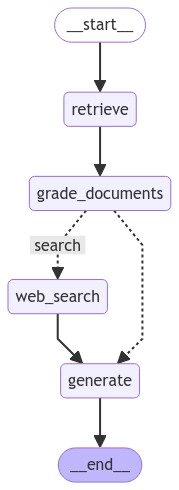

In [23]:
from IPython.display import Image, display


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [24]:
def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_answer(example)
response

{'response': 'The types of agent memory are sensory memory, short-term memory, and long-term memory. Sensory memory involves learning embedding representations for raw inputs like text and images. Short-term memory is in-context learning restricted by the context window length of the Transformer, and long-term memory involves using an external vector store for retaining and recalling information over extended periods.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

We can see from our trace that our agent follows the specified control flow:

https://smith.langchain.com/public/eb2a5dae-7a2f-4740-848e-8539ed4cbe76/r


## Evaluation

Now we've defined two different agent architectures that do roughly the same thing!

We can evaluate them. See our [conceptual guide](https://docs.smith.langchain.com/concepts/evaluation#agents) for context on agent evaluation.

### Response

First, we can assess how well [our agent performs on a set of question-answer pairs](https://docs.smith.langchain.com/tutorials/Developers/agents#response-evaluation).

We'll create a dataset and save it in LangSmith.


In [25]:
#from langsmith import Client

#client = Client()

# Create a dataset
examples = [
    (
        "How does the ReAct agent use self-reflection? ",
        "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs.",
    ),
    (
        "What are the types of biases that can arise with few-shot prompting?",
        "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias.",
    ),
    (
        "What are five types of adversarial attacks?",
        "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming.",
    ),
    (
        "Who did the Chicago Bears draft first in the 2024 NFL draft”?",
        "The Chicago Bears drafted Caleb Williams first in the 2024 NFL draft.",
    ),
    ("Who won the 2024 NBA finals?", "The Boston Celtics on the 2024 NBA finals"),
]

'''# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)'''

'# Save it\ndataset_name = "Corrective RAG Agent Testing"\nif not client.has_dataset(dataset_name=dataset_name):\n    dataset = client.create_dataset(dataset_name=dataset_name)\n    inputs, outputs = zip(\n        *[({"input": text}, {"output": label}) for text, label in examples]\n    )\n    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)'

Now, we'll use an `LLM as a grader` to compare both agent responses to our ground truth reference answer.

[Here](https://smith.langchain.com/hub/rlm/rag-answer-vs-reference) is the default prompt that we can use.

We'll use `gpt-4o` as our LLM grader.


In [26]:
from langchain import hub
#from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    answer_grader = grade_prompt_answer_accuracy | model

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_v_reference_score", "score": score}

### Trajectory

Second, [we can assess the list of tool calls](https://docs.smith.langchain.com/tutorials/Developers/agents#trajectory) that each agent makes relative to expected trajectories.

This evaluates the specific reasoning traces taken by our agents!


In [ ]:
from langsmith.schemas import Example, Run

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]

def check_trajectory_react(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    messages = root_run.outputs["messages"]
    tool_calls = find_tool_calls_react(messages)
    print(f"Tool calls ReAct agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}


def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

Finally, we can kick off our evaluations.

The results from each experiment will be logged to our `dataset_name` in LangSmith.


In [ ]:
from langsmith.evaluation import evaluate

experiment_prefix = f"react-agent-{model_tested}"
experiment_results = evaluate(
    predict_react_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_react],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    metadata={"version": metadata},
)

experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'react-agent-firefunction-v2-answer-and-tool-use-8d22a2d1' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/a8b9273b-ca33-4e2f-9f69-9bbc37f6f51b/compare?selectedSessions=a9703848-7423-49f1-a8c4-c4a495d7773e




0it [00:00, ?it/s]

Tool calls ReAct agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']
Tool calls ReAct agent: []
Tool calls ReAct agent: []
Tool calls ReAct agent: []
Tool calls ReAct agent: []
Tool calls ReAct agent: []
Tool calls ReAct agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']
Tool calls ReAct agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']
Tool calls ReAct agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']
Tool calls ReAct agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'grade_document_retrieval', 'generate_answer']
Tool calls ReAct agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']
Tool calls ReAct agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']
Tool calls ReAct agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'grade_document_retrieval', 'generate_answer']
Tool calls ReAct agent: []
To

0it [00:00, ?it/s]

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom a

We ran 3 repetitions on `Firefunction-v2` and `GPT-4o` with ReAct and Custom agents.

we can see the results logged here:

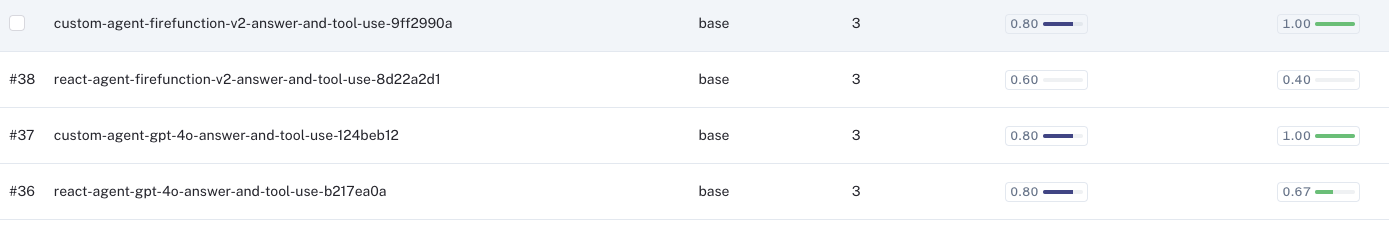

Now we can look at a summary of the results here:

https://smith.langchain.com/public/6c6c4543-1e56-4126-ab18-a84a31ff4946/d

What we can see:

* ReAct agent has freedom to select many tool use trajectories.
* But, LLMs are non-deterministic and tool-calling is challenging.
* The tool calling trajectory score is worse for ReAct than Custom.
* The effect is further worse when we moved to `Firefunction-v2`.
* But the Custom agent shows strong performance in reasoning trajectory.
* This is true even as we dial down model capacity.
* It can even be run locally [see here](https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_crag_local.ipynb)!

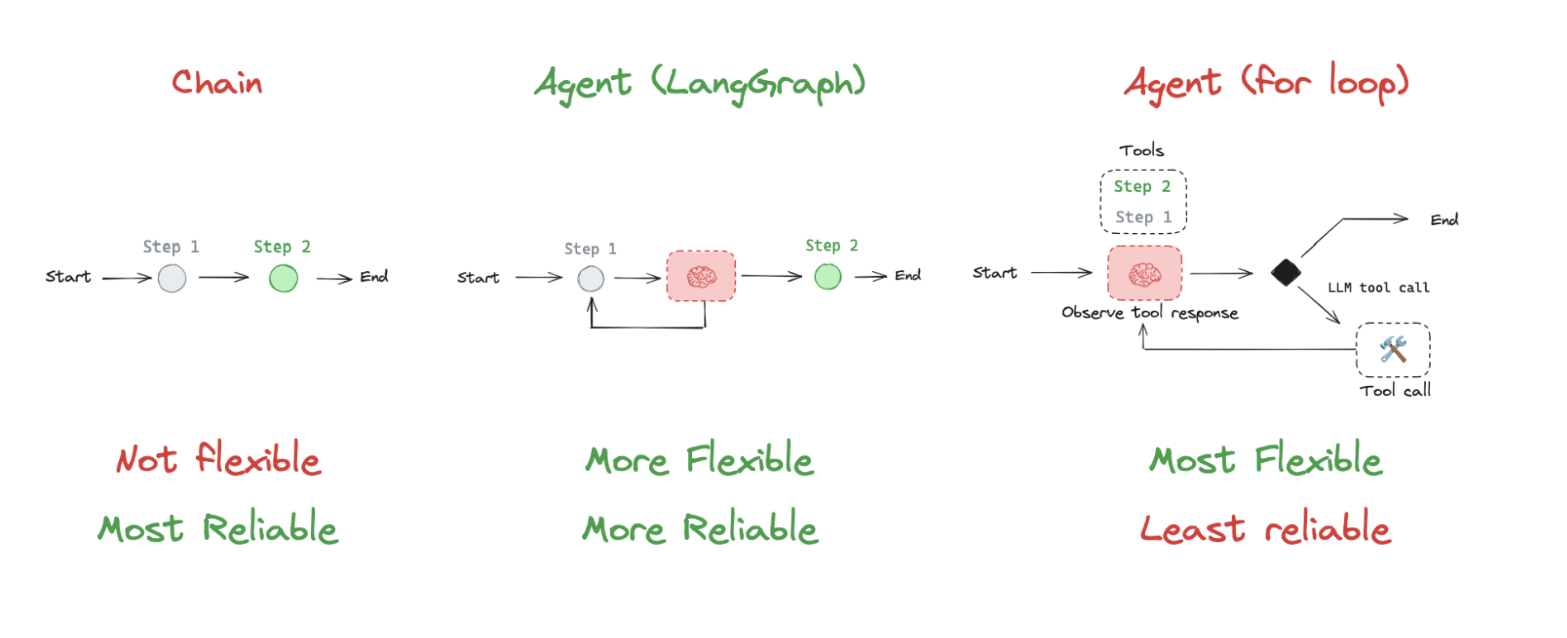